In [1]:
# @title 1. Import Libraries & Download NLTK Data
import nltk
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import string
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import io
from google.colab import files

# Download required NLTK resources
# These are necessary for tokenization, tagging, and WordNet access
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab') # Needed for newer nltk versions

print("✅ Libraries imported and NLTK data downloaded.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Libraries imported and NLTK data downloaded.


In [2]:
# @title 2. Core Helper Functions

def penn_to_wordnet(tag):
    """
    Maps NLTK Penn Treebank POS tags to WordNet POS constants.
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def get_wordnet_relations(synset):
    """
    Extracts synonyms, antonyms, hypernyms, and hyponyms from a given Synset.
    """
    if not synset:
        return {}, {}, {}, {}

    synonyms = set()
    antonyms = set()
    hypernyms = set()
    hyponyms = set()

    # 1. Synonyms & Antonyms
    # Iterate over lemmas (specific word forms in the synset)
    for lemma in synset.lemmas():
        synonyms.add(lemma.name().replace('_', ' '))
        if lemma.antonyms():
            for ant in lemma.antonyms():
                antonyms.add(ant.name().replace('_', ' '))

    # 2. Hypernyms (Parent concepts)
    for hyper in synset.hypernyms():
        # Get the first lemma name for readability
        hypernyms.add(hyper.lemmas()[0].name().replace('_', ' '))

    # 3. Hyponyms (Child concepts)
    for hypo in synset.hyponyms():
        hyponyms.add(hypo.lemmas()[0].name().replace('_', ' '))

    return list(synonyms), list(antonyms), list(hypernyms), list(hyponyms)

In [3]:
# @title 3. Build the Analysis Pipeline

def analyze_text(text):
    """
    Full pipeline: Tokenize -> POS Tag -> WSD -> Relation Extraction -> DataFrame
    """
    results = []
    stop_words = set(stopwords.words('english'))
    sentences = sent_tokenize(text)

    print(f"Processing {len(sentences)} sentences...")

    for sentence in sentences:
        # Tokenize and POS tag the sentence
        # We need the whole sentence context for Lesk WSD
        tokens = word_tokenize(sentence)
        pos_tags = nltk.pos_tag(tokens)

        for word, tag in pos_tags:
            # 1. Filter: Content words only (no stopwords or punctuation)
            if word.lower() in stop_words or word in string.punctuation or not word.isalnum():
                continue

            # 2. Map POS tag
            wn_pos = penn_to_wordnet(tag)
            if not wn_pos:
                continue # Skip words that aren't Noun, Verb, Adj, Adv

            # 3. Word Sense Disambiguation (WSD)
            # Try Lesk first (uses context overlap)
            synset = lesk(tokens, word, pos=wn_pos)

            # Fallback: If Lesk fails, pick the most common synset (lemma.01)
            if not synset:
                possible_synsets = wn.synsets(word, pos=wn_pos)
                if possible_synsets:
                    synset = possible_synsets[0]

            # 4. Extract Relations
            if synset:
                syns, ants, hypers, hypos = get_wordnet_relations(synset)
                definition = synset.definition()
                chosen_synset_name = synset.name()
            else:
                syns, ants, hypers, hypos = [], [], [], []
                definition = "No Match"
                chosen_synset_name = None

            # 5. Store Data
            results.append({
                'Original_Word': word,
                'POS': tag,
                'WN_POS': wn_pos,
                'Synset_ID': chosen_synset_name,
                'Definition': definition,
                'Synonyms': ", ".join(syns[:5]), # Top 5
                'Antonyms': ", ".join(ants[:5]),
                'Hypernyms': ", ".join(hypers[:5]),
                'Hyponyms': ", ".join(hypos[:5])
            })

    return pd.DataFrame(results)

print("✅ Pipeline function `analyze_text` created.")

✅ Pipeline function `analyze_text` created.


In [4]:
# @title 4. Visualization Function

def visualize_relations(df, target_words):
    """
    Visualizes semantic relationships for a list of target words using NetworkX.
    """
    G = nx.DiGraph()
    colors = []

    # Filter dataframe for target words (case insensitive)
    subset = df[df['Original_Word'].str.lower().isin([t.lower() for t in target_words])]

    if subset.empty:
        print("No target words found in the processed text.")
        return

    for _, row in subset.iterrows():
        word = row['Original_Word']
        synset_id = row['Synset_ID']

        if not synset_id: continue

        # Add the main word node
        G.add_node(word, type='root')

        # Add Hypernyms (Red edges)
        if row['Hypernyms']:
            for h in row['Hypernyms'].split(', '):
                G.add_edge(word, h, relation='Hypernym')

        # Add Synonyms (Blue edges)
        if row['Synonyms']:
            for s in row['Synonyms'].split(', '):
                # Avoid self-loops
                if s.lower() != word.lower():
                    G.add_edge(word, s, relation='Synonym')

        # Add Antonyms (Green edges)
        if row['Antonyms']:
            for a in row['Antonyms'].split(', '):
                G.add_edge(word, a, relation='Antonym')

    # Draw Graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Node styling
    node_sizes = [3000 if G.nodes[n].get('type') == 'root' else 1000 for n in G.nodes()]
    node_colors = ['skyblue' if G.nodes[n].get('type') == 'root' else 'lightgrey' for n in G.nodes()]

    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors,
            font_size=9, font_weight='bold', edge_color='gray', alpha=0.7)

    # Edge labels
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Semantic Network for: {', '.join(target_words)}")
    plt.show()

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Running semantic analysis...
Processing 4 sentences...

--- Summary Statistics ---
Total Content Words Processed: 22
Words with Synonyms found:     22 (100.0%)
Words with Antonyms found:     7 (31.8%)
Words with Hypernyms found:    13 (59.1%)

--- Data Sample (First 5 Rows) ---


,Original_Word,POS,WN_POS,Synset_ID,Definition,Synonyms,Antonyms,Hypernyms,Hyponyms
0,quick,JJ,a,quick.s.01,accomplished rapidly and without delay,"speedy, quick",,,
1,brown,NN,n,brown.n.02,Scottish botanist who first observed the movem...,"Robert Brown, Brown",,,
2,fox,NN,n,fox.n.03,the grey or reddish-brown fur of a fox,fox,,fur,
3,jumps,VBZ,v,derail.v.02,run off or leave the rails,"derail, jump",,travel,
4,lazy,JJ,a,lazy.s.01,moving slowly and gently,lazy,,,


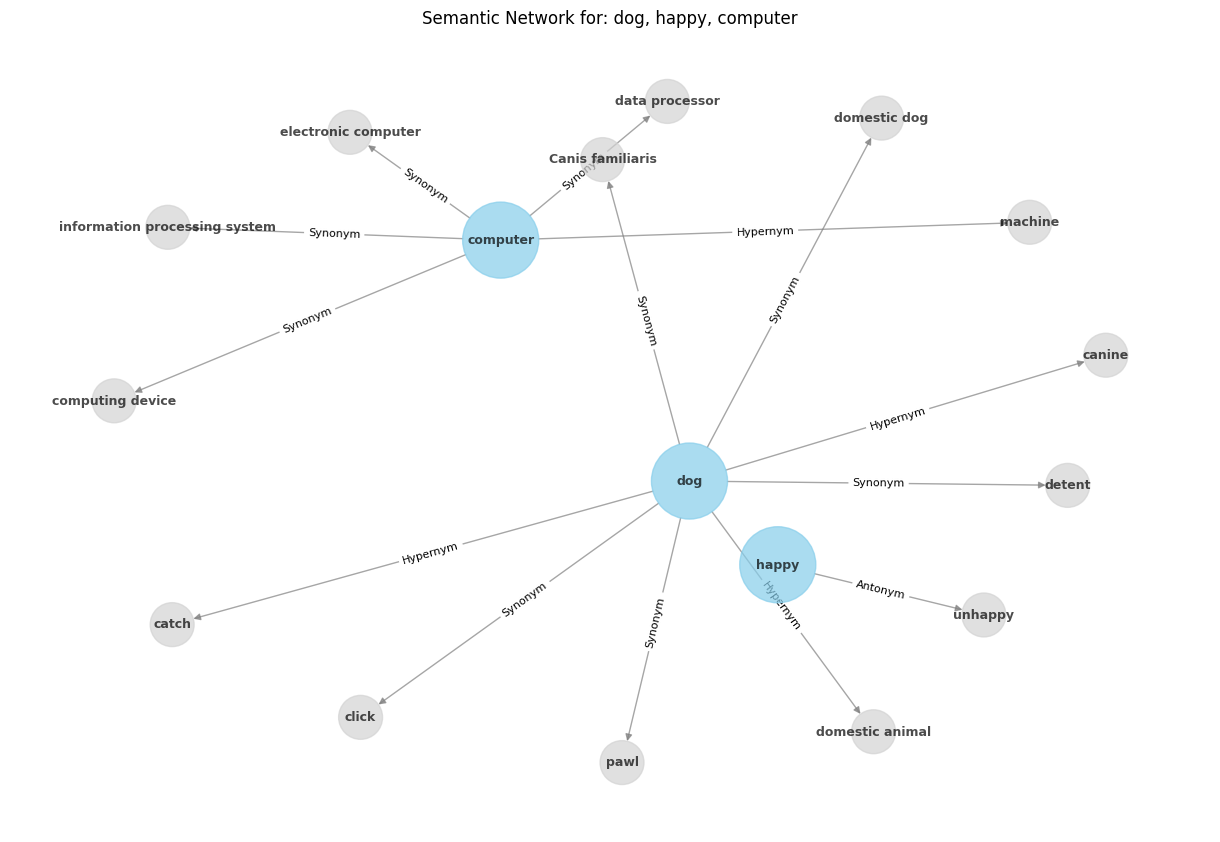


✅ Results saved to 'semantic_relations.csv'


In [6]:
# @title 5. Execute Pipeline on Sample Text

# Add the missing NLTK download here to resolve the LookupError
nltk.download('averaged_perceptron_tagger_eng') # This was the missing resource

# 1. Define Sample Text
sample_text = """
The quick brown fox jumps over the lazy dog.
The dog was happy to see the bone but the cat was angry.
Technology is advancing rapidly in the modern world.
The computer calculated the complex equation efficiently.
"""

# 2. Run Analysis
print("Running semantic analysis...")
df_results = analyze_text(sample_text)

# 3. Show Summary Statistics
total_words = len(df_results)
has_syns = len(df_results[df_results['Synonyms'] != ""])
has_ants = len(df_results[df_results['Antonyms'] != ""])
has_hyper = len(df_results[df_results['Hypernyms'] != ""])

print("\n--- Summary Statistics ---")
print(f"Total Content Words Processed: {total_words}")
print(f"Words with Synonyms found:     {has_syns} ({has_syns/total_words:.1%})")
print(f"Words with Antonyms found:     {has_ants} ({has_ants/total_words:.1%})")
print(f"Words with Hypernyms found:    {has_hyper} ({has_hyper/total_words:.1%})")

# 4. Display DataFrame Head
print("\n--- Data Sample (First 5 Rows) ---")
display(df_results.head())

# 5. Visualize Specific Words
# We pick words we know are in the text for the demo
target_words_demo = ['dog', 'happy', 'computer']
visualize_relations(df_results, target_words_demo)

# 6. Save to CSV
df_results.to_csv('semantic_relations.csv', index=False)
print("\n✅ Results saved to 'semantic_relations.csv'")